# Weibull Survival Analysis: Mastectomy Dataset

In this notebook, we'll use the **mastectomy dataset**, which contains information about breast cancer patients and their survival times. We will use the **Bayesian Weibull Model** (implemented in `PyBH`) to analyze survival data and compare patients with and without metastasis.

In [1]:
import sys
import os
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az

# Add parent directory to path to import pymc_models

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../..')))

from PyBH.SurvivalAnalysis.pymc_models import Weibull
from PyBH.SurvivalAnalysis.SurvivalAnalysis import SurvivalAnalysis

## 1. Load Data

We load the `mastectomy` dataset using PyMC's data utility.

In [2]:
try:
    # Try loading via pymc
    data = pd.read_csv(pm.get_data("mastectomy.csv"))
except:
    # Fallback to hardcoded url or local file if pm.get_data fails (for offline safety)
    print("Could not load via pm.get_data, checking local or alternative source...")
    # Assuming it works as per user request, otherwise we might need a backup source
    # data = pd.read_csv("https://raw.githubusercontent.com/pymc-devs/pymc-examples/main/examples/data/mastectomy.csv")
    raise

print(f"Dataset loaded! Shape: {data.shape}")
print(data.head())

Dataset loaded! Shape: (44, 3)
   time  event metastasized
0    23   True           no
1    47   True           no
2    69   True           no
3    70  False           no
4   100  False           no


In [3]:
wbll = Weibull()

# Use PyBH's SurvivalAnalysis class to fit the model
# This automatically handles validation and preprocessing
survival_analysis = SurvivalAnalysis(
    model=wbll,
    data=data,
    time_col='time',
    event_col='event',
    draws=1000, tune=1000, chains=2
)

   -> Mode: Bayesian (PyMC)


c:\Users\jeanv\miniconda3\envs\CausalPy\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]


c:\Users\jeanv\miniconda3\envs\CausalPy\Lib\site-packages\rich\live.py:260: UserWarning: install "ipywidgets" for 
Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## 2. Preprocessing

The dataset has:
- `time`: survival time
- `event`: 1 if event observed (death), 0 if censored
- `metastasized`: 'yes' or 'no'

In [4]:
# Ensure event column is numeric
data['event'] = data['event'].astype(int)
print(data['metastasized'].value_counts())

metastasized
yes    32
no     12
Name: count, dtype: int64


## 3. Fit Weibull Model (All Patients)

First, we fit the model on the entire population to get a global survival curve.

In [5]:
# Summary of the global model
survival_analysis.summary()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.875,0.148,0.613,1.158,0.004,0.003,1685.0,1553.0,1.0
beta,192.066,51.445,111.253,286.809,1.574,1.929,1255.0,1070.0,1.0


<Axes: xlabel='Time', ylabel='Survival Probability'>

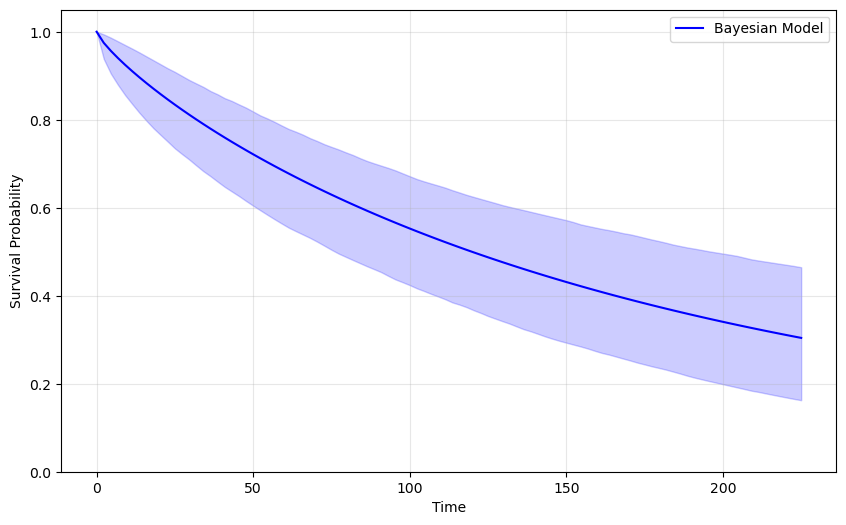

In [7]:
survival_analysis.plot_survival_function()

## 4. Compare Groups: Metastasis vs No Metastasis

We fit two separate models to see the impact of metastasis on survival.

In [8]:
data_yes = data[data['metastasized'] == 'yes']
data_no = data[data['metastasized'] == 'no']

print(f"N (Metastasized): {len(data_yes)}")
print(f"N (No Metastasis): {len(data_no)}")

wbll_yes = Weibull()
print("\nFitting Model: Metastasis = YES")
sa_yes = SurvivalAnalysis(model=wbll_yes, data=data_yes, time_col='time', event_col='event', draws=1000, tune=1000, chains=2, progressbar=False)

wbll_no = Weibull()
print("\nFitting Model: Metastasis = NO")
sa_no = SurvivalAnalysis(model=wbll_no, data=data_no, time_col='time', event_col='event', draws=1000, tune=1000, chains=2, progressbar=False)

N (Metastasized): 32
N (No Metastasis): 12

Fitting Model: Metastasis = YES
   -> Mode: Bayesian (PyMC)


c:\Users\jeanv\miniconda3\envs\CausalPy\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



Fitting Model: Metastasis = NO
   -> Mode: Bayesian (PyMC)


c:\Users\jeanv\miniconda3\envs\CausalPy\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 18 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


### Compare Posteriors
Let's look at the posterior distributions for Mean Survival Time or just the parameters.

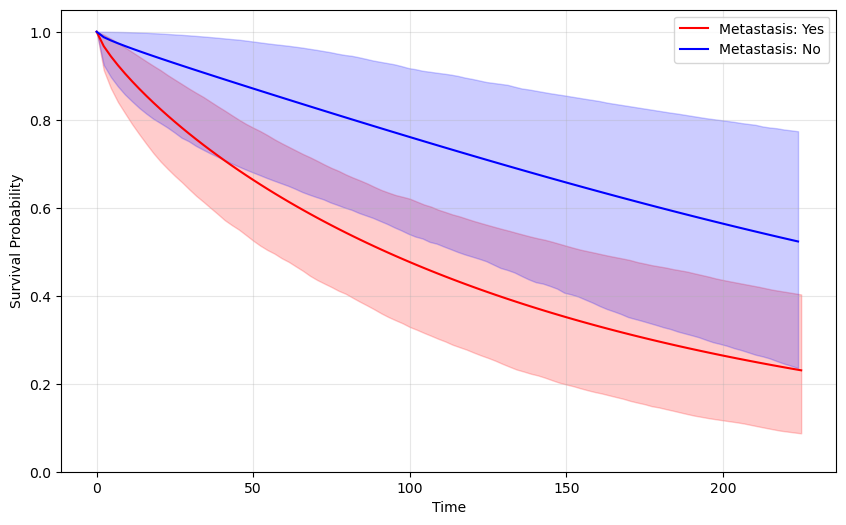

In [14]:
limit = data['time'].max()
times = np.linspace(0, limit, 100)

fig, ax = plt.subplots(figsize=(10, 6))
surv_yes = sa_yes.plot_survival_function(ax, label='Metastasis: Yes', color="red")
surv_no = sa_no.plot_survival_function(ax, label='Metastasis: No', color="Blue");

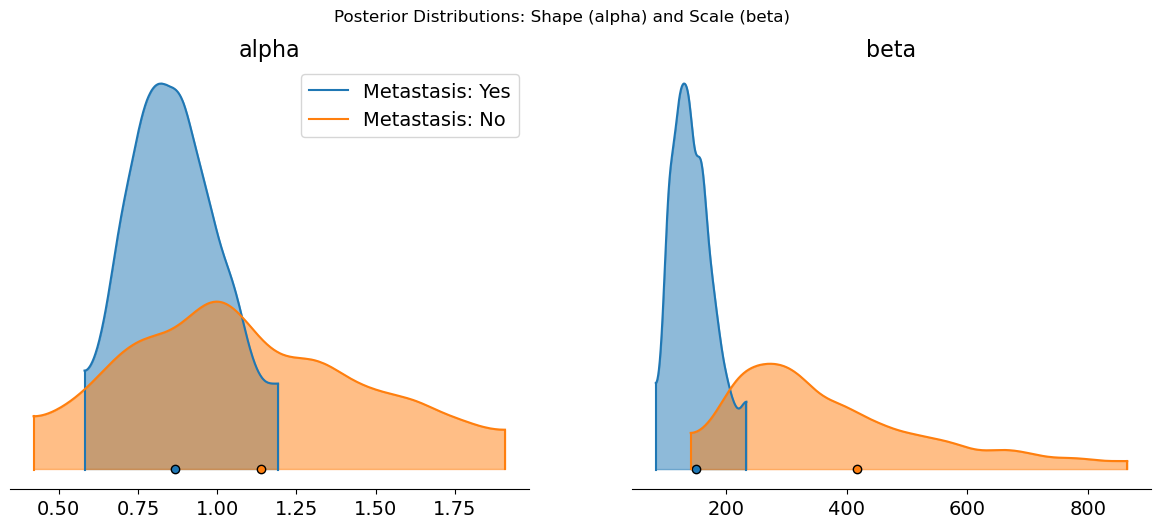

In [15]:
import arviz as az
import matplotlib.pyplot as plt
# Compare posteriors for Alpha (Shape) and Beta (Scale)
# We pass a list of InferenceData objects and their labels
az.plot_density(
    [sa_yes.idata, sa_no.idata], 
    var_names=["alpha", "beta"], 
    data_labels=["Metastasis: Yes", "Metastasis: No"],
    shade=0.5
)
plt.suptitle("Posterior Distributions: Shape (alpha) and Scale (beta)")
plt.show()